In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid , save_image

# Path initialization
sys.path.insert(0, "../vae_architectures")
from VAE import VAE1
from CondVAE import CondVAE

from dataset import (ATTR_TO_IX_DICT, ATTR_IX_TO_KEEP, IX_TO_ATTR_DICT, N_ATTRS, 
                     FaceData_with_Attributes, tensor_to_attributes)

%matplotlib inline

### Data

In [3]:
def show(file_name, name, img, dpi=300, fontsize=10):
    npimg = img.numpy().transpose(1, 2, 0) 
    plt.figure(dpi=dpi)
    plt.title(file_name, fontsize=fontsize)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(npimg)
    plt.savefig(name)
    plt.show()

In [4]:
df_attr = pd.read_csv("../data/dataframes/df_attr.csv")
img_path = "../../img_align_celeba"

img_names = {"train": df_attr.img_name.values[:55000], "val": df_attr.img_name.values[55000:]}
datasets = {phase: FaceData_with_Attributes(img_names[phase], img_path) 
                for phase in ["train", "val"]}

dataloaders = {phase: DataLoader(datasets[phase], batch_size=128, shuffle=True, num_workers=2) 
               for phase in ["train", "val"]}

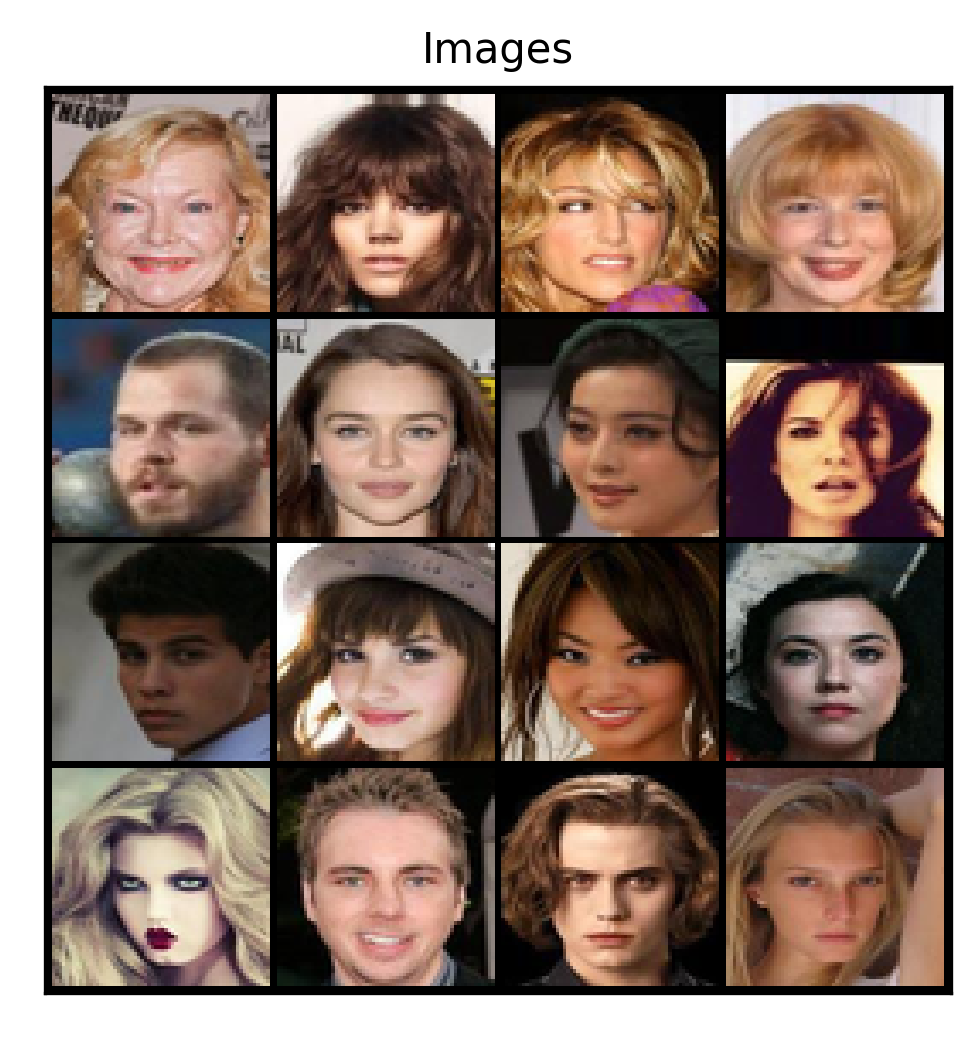

In [7]:
data, attr = next(iter(dataloaders["train"]))

show("Images", 'ds', make_grid((data[:16]).cpu(), 4))

### Model

In [62]:
import torchvision

In [63]:
model = torchvision.models.resnet34(pretrained=True)
model.fc = nn.Linear(512, N_ATTRS) 
model = model.cuda()

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.001)
criterion = nn.BCELoss()

In [93]:
try:
    while True:
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            for i, (imgs, attr) in enumerate(dataloaders[phase]):
                num_attrs = np.array(attr.shape).prod()
                batch_size = imgs.size(0)
                
                imgs = imgs.float().cuda()
                
                output = model(imgs)

                output = torch.sigmoid(output).cpu()
                loss = criterion(output, attr)
                
                prediction = torch.zeros_like(output)
                prediction[output > 0.5] = 1
                
                
                running_rights_all = (attr == prediction).sum() 
                running_rights_joint = (attr == prediction).sum(dim=1)
                running_rights_joint = (running_rights_joint == N_ATTRS).sum().float()
                
                if i % 50 == 49:
                    print("{}: accuracy for all attributes: {}, accuracy for joint attributes: {}".format(phase, running_rights_all / num_attrs,
                                                                                                  running_rights_joint / batch_size))

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

        
except:
    print("Training was interupted")
    

train: accuracy for all attributes: 0.9913194179534912, accuracy for joint attributes: 0.84375
train: accuracy for all attributes: 0.9926215410232544, accuracy for joint attributes: 0.8828125
train: accuracy for all attributes: 0.9904513955116272, accuracy for joint attributes: 0.875
train: accuracy for all attributes: 0.9934895634651184, accuracy for joint attributes: 0.8984375
train: accuracy for all attributes: 0.9939236044883728, accuracy for joint attributes: 0.890625
train: accuracy for all attributes: 0.9926215410232544, accuracy for joint attributes: 0.8828125
train: accuracy for all attributes: 0.9921875, accuracy for joint attributes: 0.890625
train: accuracy for all attributes: 0.9878472089767456, accuracy for joint attributes: 0.796875
val: accuracy for all attributes: 0.9396701455116272, accuracy for joint attributes: 0.34375
Training was interupted


### Test

In [94]:
attr_to_accuracy = {
    'Heavy_Makeup': [],
    'Wearing_Hat': [],
    'Male': [],
    'Smiling': [], 
    'Eyeglasses': [], 
}
attr_of_interest_to_idx = {
    'Heavy_Makeup':8, 
    'Wearing_Hat':17, 
    'Male': 9, 
    'Smiling': 14, 
    'Eyeglasses': 6}

In [95]:
model.eval()

for i, (imgs, attr) in tqdm(enumerate(dataloaders["val"])):
    num_attrs = np.array(attr.shape).prod()
    batch_size = imgs.size(0)

    imgs = imgs.float().cuda()

    output = model(imgs)

    output = torch.sigmoid(output).cpu()
    loss = criterion(output, attr)

    prediction = torch.zeros_like(output)
    prediction[output > 0.5] = 1
    
    running_rights_all = (attr == prediction)
    
    for attr_name in attr_of_interest_to_idx.keys():
        ind = attr_of_interest_to_idx[attr_name]
        attr_to_accuracy[attr_name].append(running_rights_all[:, ind].sum().float() / batch_size)


for attr_name in attr_to_accuracy.keys():
    print("Accuraci for attr '{}': {}".format(attr_name, np.mean(attr_to_accuracy[attr_name])))


94it [00:42,  2.19it/s]

Accuraci for attr 'Heavy_Makeup': 0.9002196788787842
Accuraci for attr 'Wearing_Hat': 0.9903324842453003
Accuraci for attr 'Male': 0.9745977520942688
Accuraci for attr 'Smiling': 0.9144583344459534
Accuraci for attr 'Eyeglasses': 0.9899435043334961
